In [97]:
# First we will import the necessary Library 

import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import math
import os
import datetime as dt
import matplotlib.pyplot as plt


# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [98]:
# Pull Historical Data from SPY

spy_ticker = yf.Ticker("SPY")
spy = spy_ticker.history(period="max")
spy

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-01-29,25.352041,25.352041,25.225911,25.334023,1003200,0.0,0
1993-02-01,25.352053,25.514219,25.352053,25.514219,480500,0.0,0
1993-02-02,25.496192,25.586284,25.442136,25.568266,201300,0.0,0
1993-02-03,25.604304,25.856563,25.586286,25.838545,529400,0.0,0
1993-02-04,25.928637,26.000711,25.640341,25.946655,531500,0.0,0
...,...,...,...,...,...,...,...
2022-10-03,361.079987,368.549988,359.209991,366.609985,89756500,0.0,0
2022-10-04,372.399994,378.000000,366.570007,377.970001,103602800,0.0,0
2022-10-05,373.390015,379.459991,370.950012,377.089996,88065700,0.0,0


In [99]:
spy.index = pd.to_datetime(spy.index)
spy.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
spy.reset_index(inplace=True)

In [100]:
closed_stock = spy[['Date','Close']]
df = spy[['Date','Close']]
print("Shape of dataframe:", closed_stock.shape)

Shape of dataframe: (7478, 2)


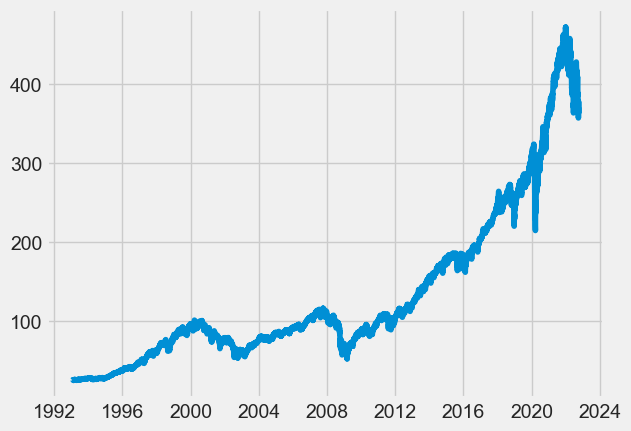

In [101]:
# Graph of SPY Performance
plt.plot(closed_stock.Date, closed_stock['Close'])

In [102]:
#Apply Normalization on Closed Price

df.drop(['Date'], axis=1, inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
closed=scaler.fit_transform(np.array(df).reshape(-1,1))
print(closed.shape)

(7478, 1)


C:\Users\leona\anaconda3\envs\tf\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [103]:
training_size=int(len(closed)*0.60)
test_size=len(closed)-training_size
train_data,test_data=closed[0:training_size,:], closed[training_size:len(closed),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (4486, 1)
test_data:  (2992, 1)


In [104]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]
#incrementally adding the previous lists of each time stamp for each row

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [105]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (4470, 15)
y_train:  (4470,)
X_test:  (2976, 15)
y_test (2976,)


In [106]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (4470, 15, 1)
X_test:  (2976, 15, 1)


In [107]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [108]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
140/140 [==============================] - 2s 6ms/step - loss: 0.0019 - val_loss: 0.0620
Epoch 2/200
140/140 [==============================] - 1s 5ms/step - loss: 1.3512e-05 - val_loss: 0.0504
Epoch 3/200
140/140 [==============================] - 1s 4ms/step - loss: 1.0187e-05 - val_loss: 0.0472
Epoch 4/200
140/140 [==============================] - 1s 4ms/step - loss: 1.0188e-05 - val_loss: 0.0456
Epoch 5/200
140/140 [==============================] - 1s 4ms/step - loss: 1.0159e-05 - val_loss: 0.0446
Epoch 6/200
140/140 [==============================] - 1s 4ms/step - loss: 9.7795e-06 - val_loss: 0.0436
Epoch 7/200
140/140 [==============================] - 1s 4ms/step - loss: 9.7158e-06 - val_loss: 0.0431
Epoch 8/200
140/140 [==============================] - 1s 4ms/step - loss: 9.7911e-06 - val_loss: 0.0421
Epoch 9/200
140/140 [==============================] - 1s 4ms/step - loss: 9.7395e-06 - val_loss: 0.0416
Epoch 10/200
140/140 [==============================] - 1s 

140/140 [==============================] - 1s 4ms/step - loss: 6.2767e-06 - val_loss: 0.0033
Epoch 79/200
140/140 [==============================] - 1s 4ms/step - loss: 6.1009e-06 - val_loss: 0.0030
Epoch 80/200
140/140 [==============================] - 1s 4ms/step - loss: 6.1717e-06 - val_loss: 0.0031
Epoch 81/200
140/140 [==============================] - 1s 4ms/step - loss: 6.1751e-06 - val_loss: 0.0029
Epoch 82/200
140/140 [==============================] - 1s 4ms/step - loss: 6.2047e-06 - val_loss: 0.0030
Epoch 83/200
140/140 [==============================] - 1s 4ms/step - loss: 5.7851e-06 - val_loss: 0.0028
Epoch 84/200
140/140 [==============================] - 1s 5ms/step - loss: 6.2601e-06 - val_loss: 0.0025
Epoch 85/200
140/140 [==============================] - 1s 5ms/step - loss: 6.7328e-06 - val_loss: 0.0028
Epoch 86/200
140/140 [==============================] - 1s 4ms/step - loss: 6.4053e-06 - val_loss: 0.0026
Epoch 87/200
140/140 [==============================] - 1s 

Epoch 154/200
140/140 [==============================] - 1s 4ms/step - loss: 5.0809e-06 - val_loss: 5.2653e-04
Epoch 155/200
140/140 [==============================] - 1s 4ms/step - loss: 5.3550e-06 - val_loss: 5.2998e-04
Epoch 156/200
140/140 [==============================] - 1s 4ms/step - loss: 5.0423e-06 - val_loss: 5.1654e-04
Epoch 157/200
140/140 [==============================] - 1s 4ms/step - loss: 5.2175e-06 - val_loss: 5.4642e-04
Epoch 158/200
140/140 [==============================] - 1s 4ms/step - loss: 4.9713e-06 - val_loss: 5.3373e-04
Epoch 159/200
140/140 [==============================] - 1s 4ms/step - loss: 5.2839e-06 - val_loss: 5.3927e-04
Epoch 160/200
140/140 [==============================] - 1s 4ms/step - loss: 4.9877e-06 - val_loss: 5.4427e-04
Epoch 161/200
140/140 [==============================] - 1s 4ms/step - loss: 5.6192e-06 - val_loss: 5.1913e-04
Epoch 162/200
140/140 [==============================] - 1s 5ms/step - loss: 5.5312e-06 - val_loss: 5.5615e-04
E

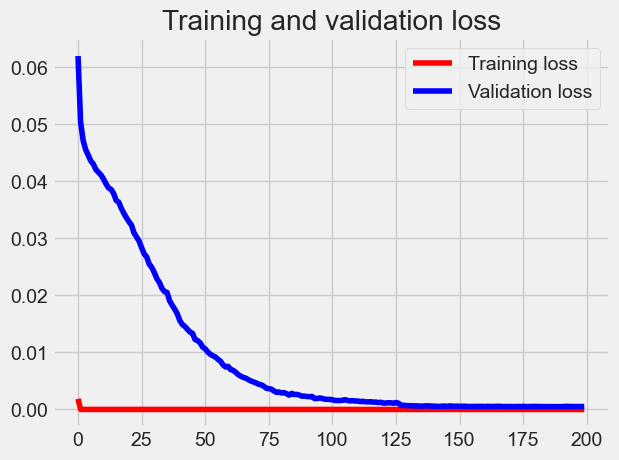

<Figure size 640x480 with 0 Axes>

In [109]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [110]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

93/93 [==============================] - 0s 1ms/step


((4470, 1), (2976, 1))

In [111]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [112]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.9468040677355523
Train data MSE:  0.8964379426805882
Train data MAE:  0.6285613254146021
-------------------------------------------------------------------------------------
Test data RMSE:  10.134645339809778
Test data MSE:  102.71103616372804
Test data MAE:  8.002215713583013


In [113]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9985133933995454
Test data explained variance regression score: 0.9912054935286253


In [114]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9985102718581975
Test data R2 score: 0.9899706034705194


In [115]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closed)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closed)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closed)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': closed_stock['Date'],
                       'original_close': closed_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (7478, 1)
Test predicted data:  (7478, 1)


In [116]:
# Predicting next 2 days

x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.80288587 0.78790429 0.78081594 0.76679585 0.75865655 0.75657702
 0.77256486 0.75525776 0.74271341 0.76379946 0.78920118 0.78723343
 0.77853518 0.75525776 0.76211059]
1 day output [[0.7670911]]
[0.8028858710848381, 0.7879042897055494, 0.7808159398648623, 0.7667958492124595, 0.7586565470165723, 0.7565770247730575, 0.7725648618130037, 0.7552577557721429, 0.7427134066711693, 0.7637994646973735, 0.7892011762395783, 0.787233429852035, 0.7785351801370618, 0.7552577557721429, 0.7621105909347534, 0.7670910954475403]
2 day input [0.78790429 0.78081594 0.76679585 0.75865655 0.75657702 0.77256486
 0.75525776 0.74271341 0.76379946 0.78920118 0.78723343 0.77853518
 0.75525776 0.76211059 0.7670911 ]
2 day output [[0.77266985]]
[0.7879042897055494, 0.7808159398648623, 0.7667958492124595, 0.7586565470165723, 0.7565770247730575, 0.7725648618130037, 0.7552577557721429, 0.7427134066711693, 0.7637994646973735, 0.7892011762395783, 0.787233429852035, 0.7785351801370618, 0.7552577557721429, 0.7

In [117]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20]


In [118]:
temp_mat = np.empty((len(last_days)+len(day_pred)+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closed[len(closed)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

new = new_pred_plot.iloc[:16]
new2 = new_pred_plot.iloc[15:]


fig = go.Figure()
fig.add_trace(go.Scatter(x=new_pred_plot.index, y=new['last_original_days_value'],
                    mode='lines',
                    name='Last 15 days close price',
                    line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=new2.index, y=new2['next_predicted_days_value'],
                    mode='lines+markers',
                    name='Predicted next 5 days close price',
                    line=dict(color='firebrick', width=4)))

#names = cycle(['Last 15 days close price','Predicted next 5 days close price'])

#fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      #new_pred_plot['next_predicted_days_value']],
              #labels={'value': 'Stock price','index': 'Timestamp'},  markers=True)


fig.update_layout(title_text='Compare last 15 days vs next 5 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

#fig.for_each_trace(lambda t:  t.update(name = next(names)))


fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [119]:
lstmdf=closed.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

lstmdf_1 = pd.DataFrame({
    'close price':lstmdf
})

lstmdf_2 = lstmdf_1.iloc[len(lstmdf_1)-5:]

names = cycle(['Close Price'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=lstmdf_1.index, y=lstmdf_1['close price'],
                    mode='lines',
                    name='Past Close Price',
                    line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=lstmdf_2.index, y=lstmdf_2['close price'],
                    mode='lines',
                    name='Predicted Close Price',
                    line=dict(color='firebrick', width=4)))

fig.update_layout(title_text='Closing Stock Price With Predicted Close Price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.show()